In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math

In [2]:
network = pd.read_csv('network.csv')
activities = pd.read_csv('activities_dataframe.csv', index_col=False)

In [3]:
network.head()

,linkId,linkLength,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,fromLocationX,fromLocationY,toLocationX,toLocationY
0,0,75.065,11.175972,600.0,1.0,null;car;walk;bike,5004035.0,residential,0,1,551370.872255,4.183680e+06,551296.615289,4.183668e+06
1,1,75.065,11.175972,600.0,1.0,null;car;walk;bike,5004035.0,residential,1,0,551296.615289,4.183668e+06,551370.872255,4.183680e+06
2,10,146.110,12.517089,600.0,1.0,null;car;walk;bike,7448875.0,unclassified,8,9,553480.804065,4.180423e+06,553626.820226,4.180434e+06
3,100,26.915,24.587139,600.0,1.0,null;car;walk;bike,8915003.0,tertiary,78,79,548168.667811,4.177638e+06,548160.987001,4.177613e+06
4,1000,12.260,12.517089,600.0,1.0,null;car;walk;bike,8916220.0,service,750,751,543445.574811,4.181818e+06,543446.681689,4.181830e+06


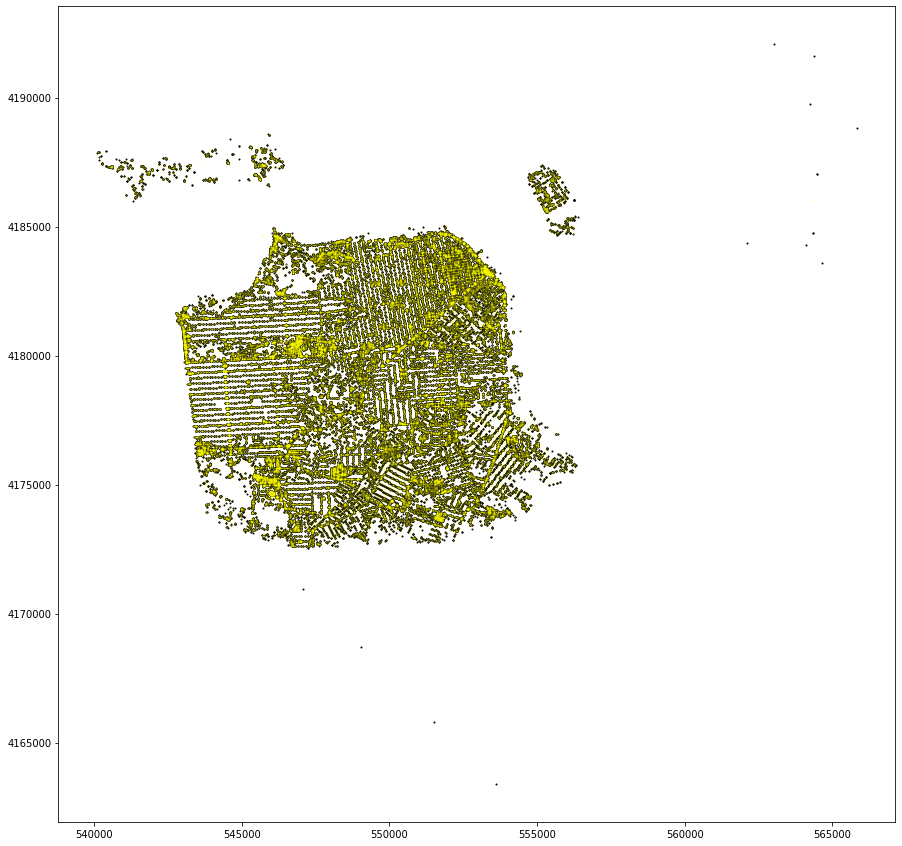

In [4]:
plt.figure(figsize=(15, 15))
plt.scatter(network['fromLocationX'], network['fromLocationY'], s = 1, color=['black'])
plt.scatter(network['fromLocationX'], network['toLocationY'], s = 1, alpha = 0.1, color=['yellow'])

In [5]:
network_loc = network[['attributeOrigType', 'fromLocationX', 'fromLocationY']]

In [6]:
network_loc["attributeOrigType"].value_counts().nlargest(n=5)

residential    28890
footway        19480
service         8390
tertiary        7216
primary         6498
Name: attributeOrigType, dtype: int64

In [7]:
markers = {"residential": "X", "footway": "s"}

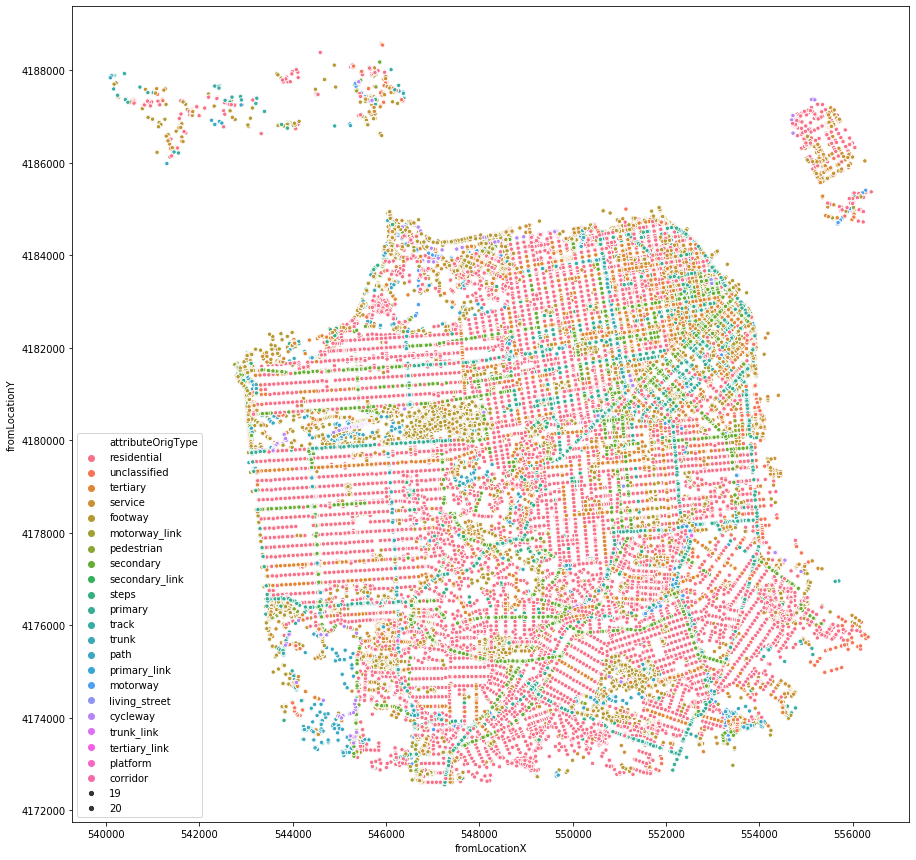

In [31]:
plt.figure(figsize=(15, 15))
sns.scatterplot(x="fromLocationX", y="fromLocationY",
              hue="attributeOrigType",
              data=network_loc, size=20,
                markers=markers);

In [9]:
activities = activities.set_index('person_id').fillna(0).drop('Unnamed: 0', 1) 

In [10]:
activities['act_start_time'] = activities['act_start_time'].astype(str)
activities['act_end_time'] = activities['act_end_time'].astype(str)
activities['act_start_time'] = activities['act_start_time'].replace('0', '00:00:00')
activities['act_end_time'] = activities['act_end_time'].replace('0', '00:00:00')

In [11]:
activities.head()
# HOME time should be accounted for during early_mroning_start and night_end

,act_num,act_type,act_nearest_link,act_start_time,act_end_time
person_id,,,,,
010100-2012000073297-0-813746,1,Home,20972,00:00:00,08:18:00
010100-2012000073297-0-813746,2,Work,78866,08:26:40,19:04:00
010100-2012000073297-0-813746,3,Home,20972,19:12:44,00:00:00
010100-2012000073297-0-813747,1,Home,20972,00:00:00,14:19:00
010100-2012000073297-0-813747,2,Shopping,32192,14:21:47,23:09:00


In [12]:
activities["act_type"].value_counts().nlargest(n=10)

Home          113304
Work           17543
Other          13850
Shopping       12106
Escort          8880
School          6340
Eatout          2972
Social          1800
University      1430
Name: act_type, dtype: int64

In [13]:
# joining table used later for adding the X, Y column to the link dfs
network_link = network[['linkId', 'fromLocationX', 'fromLocationY']]
network_link.head()

,linkId,fromLocationX,fromLocationY
0,0,551370.872255,4.183680e+06
1,1,551296.615289,4.183668e+06
2,10,553480.804065,4.180423e+06
3,100,548168.667811,4.177638e+06
4,1000,543445.574811,4.181818e+06


In [14]:
# check uniqueness, one linkId coressponds to one single x, y location
network.loc[network['linkId'] == 20972]

,linkId,linkLength,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,fromLocationX,fromLocationY,toLocationX,toLocationY
12194,20972,84.869,12.517089,600.0,1.0,null;car;walk;bike,28319173.0,service,11787,11788,551536.961363,4.184756e+06,551453.571563,4.184743e+06


In [15]:
# filtering timestamp into seperate dfs
early_morning_start = activities[(activities['act_start_time'] >= '00:00:00') & (activities['act_start_time'] < '06:00:00')]
am_peak_start = activities[(activities['act_start_time'] >= '06:00:00') & (activities['act_start_time'] < '09:00:00')]
mid_day_start = activities[(activities['act_start_time'] >= '09:00:00') & (activities['act_start_time'] < '16:00:00')]
pm_peak_start = activities[(activities['act_start_time'] >= '16:00:00') & (activities['act_start_time'] < '19:00:00')]
night_start = activities[(activities['act_start_time'] >= '19:00:00') & (activities['act_start_time'] < '23:59:59')]

In [16]:
early_morning_end = activities[(activities['act_end_time'] >= '00:00:01') & (activities['act_end_time'] < '06:00:00')]
am_peak_end = activities[(activities['act_end_time'] >= '06:00:00') & (activities['act_end_time'] < '09:00:00') & (activities['act_start_time'] >= '00:00:01')]
mid_day_end = activities[(activities['act_end_time'] >= '09:00:00') & (activities['act_end_time'] < '16:00:00')]
pm_peak_end = activities[(activities['act_end_time'] >= '16:00:00') & (activities['act_end_time'] < '19:00:00')]
night_end_part1 = activities[(activities['act_end_time'] >= '19:00:00')]
night_end_part2 = activities[(activities['act_end_time'] == '00:00:00')]
night_end = pd.concat([night_end_part1, night_end_part2])

In [17]:
# concatnating dfs to merge the leave/arrive in the same time period together
early_morning = pd.concat([early_morning_start, early_morning_end])
am_peak = pd.concat([am_peak_start, am_peak_end])
mid_day = pd.concat([mid_day_start, mid_day_end])
pm_peak = pd.concat([pm_peak_start, pm_peak_end])
night = pd.concat([night_start, night_end])

In [18]:
# adjusting index columns
early_morning = early_morning.reset_index().drop_duplicates(subset='person_id',keep='first').set_index('person_id')
am_peak = am_peak.reset_index().drop_duplicates(subset='person_id', keep='first').set_index('person_id')
mid_day = mid_day.reset_index().drop_duplicates(subset='person_id', keep='first').set_index('person_id')
pm_peak = pm_peak.reset_index().drop_duplicates(subset='person_id', keep='first').set_index('person_id')
night = night.reset_index().drop_duplicates(subset='person_id', keep='first').set_index('person_id')

In [19]:
# color -> location type color map
color_type = {'Work': 'red', 'Home': 'blue', 'Other': 'black', 'Shopping': 'yellow', 
             'Escort': 'pink', 'Social': 'green', 'School': 'orange', 'University': 'purple', 'Eatout': 'grey'}

In [20]:
# linkId to location type map for each linkId, since one linkId at most corresponds to one type of location
link_to_type = activities[['act_type', 'act_nearest_link']].drop_duplicates('act_nearest_link').\
set_index(['act_nearest_link'])
link_to_type.head()

,act_type
act_nearest_link,
20972,Home
78866,Work
32192,Shopping
7272,Home
50422,Other


In [21]:
# convert helper function to produce the link df for graphing
def convert(df):
    new_df = df['act_nearest_link'].value_counts().to_frame().reset_index().\
    rename(columns={'index':'linkId', 'act_nearest_link': 'size'}).\
    join(network_link.set_index('linkId'), 'linkId').join(link_to_type, 'linkId')
    return new_df

In [22]:
early_morning_link = convert(early_morning)
am_peak_link = convert(am_peak)
mid_day_link = convert(mid_day)
pm_peak_link = convert(pm_peak)
night_link = convert(night)

In [23]:
# in case too much overlapping during the morning peaks
am_peak_start_link = convert(am_peak_start)
am_peak_end_link = convert(am_peak_end)

In [24]:
early_morning_link.head()

,linkId,size,fromLocationX,fromLocationY,act_type
0,22144,609,548146.405296,4.180613e+06,Home
1,31334,477,550988.355399,4.181990e+06,Home
2,7458,407,548814.479805,4.182479e+06,Other
3,87988,393,546396.824546,4.179948e+06,Home
4,88014,385,545638.003213,4.179901e+06,Home


In [25]:
print(early_morning_link.nlargest(1, 'size'),
      am_peak_link.nlargest(1, 'size'),
      mid_day_link.nlargest(1, 'size'),
      pm_peak_link.nlargest(1, 'size'),
      night_link.nlargest(1, 'size'),)

   linkId  size  fromLocationX  fromLocationY act_type
0   22144   609  548146.405296   4.180613e+06     Home    linkId  size  fromLocationX  fromLocationY act_type
0   15468   296  549706.181992   4.182010e+06    Other    linkId  size  fromLocationX  fromLocationY act_type
0    7458   256  548814.479805   4.182479e+06    Other    linkId  size  fromLocationX  fromLocationY act_type
0   22144   492  548146.405296   4.180613e+06     Home    linkId  size  fromLocationX  fromLocationY act_type
0   31334   477  550988.355399   4.181990e+06     Home


Text(0.5, 1.0, 'Early morning')

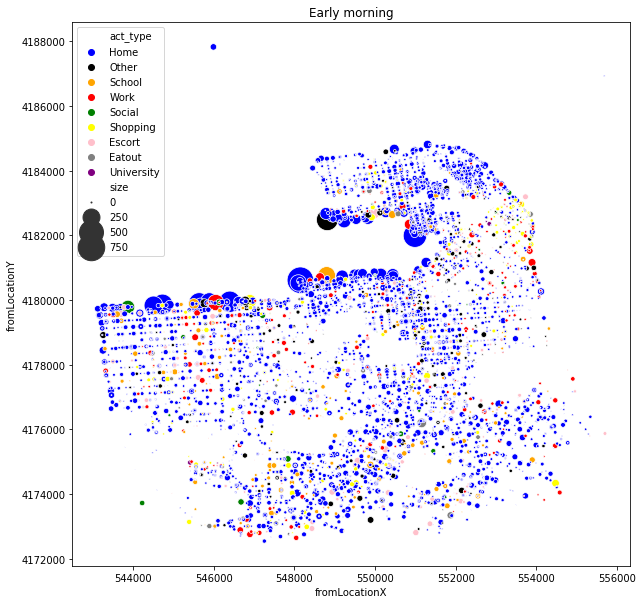

In [26]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="fromLocationX", y="fromLocationY",
              hue="act_type",
              data=early_morning_link,
              size='size',
              sizes=(1, 700),
              palette=color_type).set_title('Early morning')

Text(0.5, 1.0, 'AM Peak')

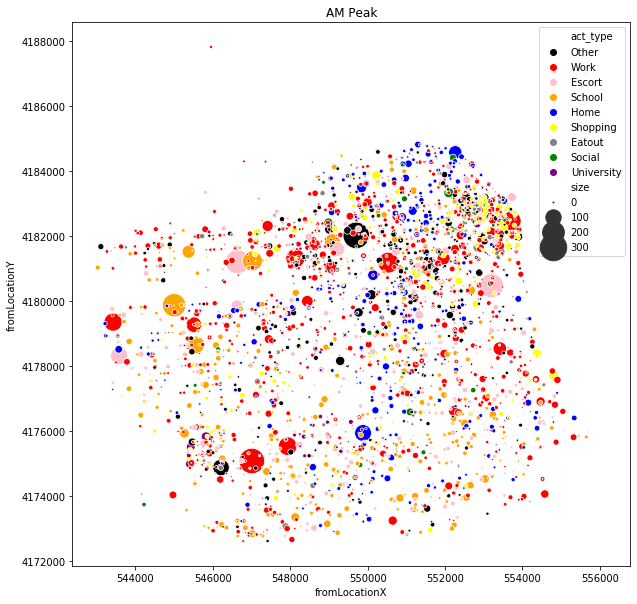

In [27]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="fromLocationX", y="fromLocationY",
              hue="act_type",
              data=am_peak_link,
              size='size',
              sizes=(1, 700),
              palette=color_type).set_title('AM Peak')

Text(0.5, 1.0, 'Mid Day')

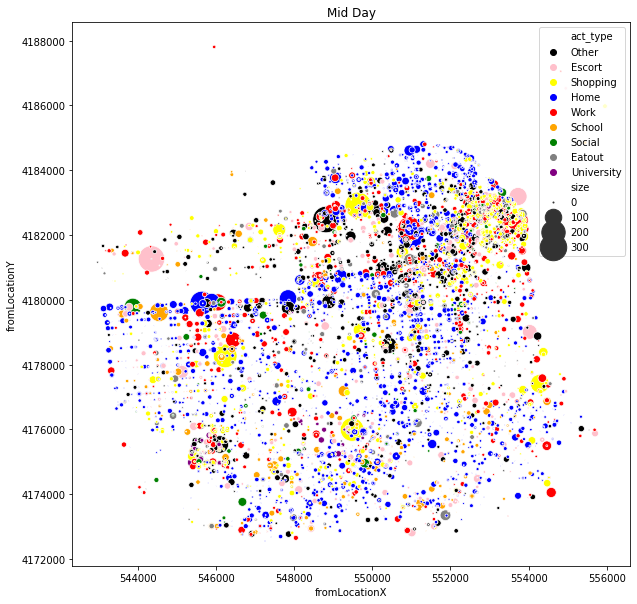

In [28]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="fromLocationX", y="fromLocationY",
              hue="act_type",
              data=mid_day_link,
              size='size',
              sizes=(1, 700),
              palette=color_type).set_title('Mid Day')

Text(0.5, 1.0, 'PM Peak')

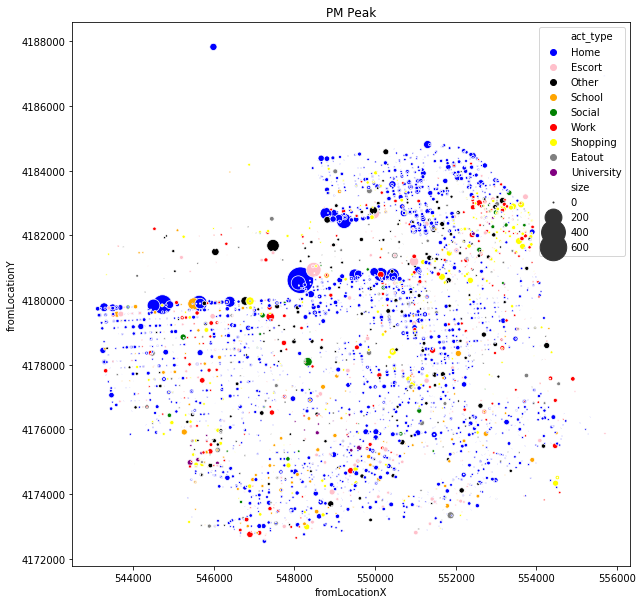

In [29]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="fromLocationX", y="fromLocationY",
              hue="act_type",
              data=pm_peak_link,
              size='size',
              sizes=(1, 700),
              palette=color_type).set_title('PM Peak')

Text(0.5, 1.0, 'PM Peak')

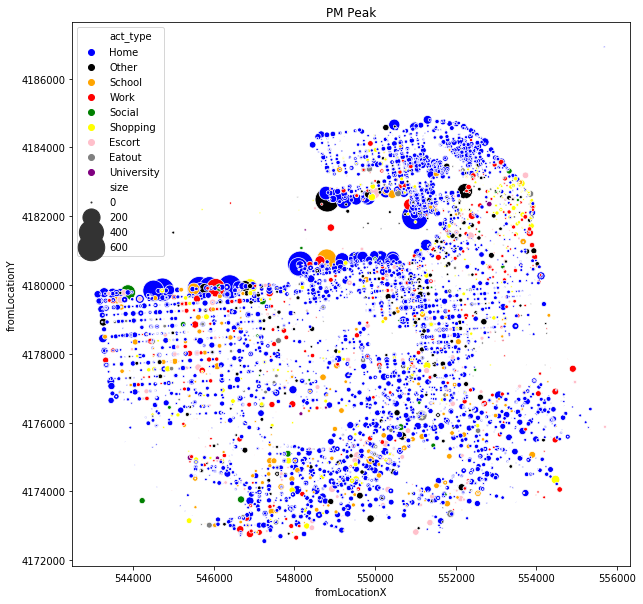

In [30]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="fromLocationX", y="fromLocationY",
              hue="act_type",
              data=night_link,
              size='size',
              sizes=(1, 700),
              palette=color_type).set_title('PM Peak')

Text(0.5, 1.0, 'AM Peak')

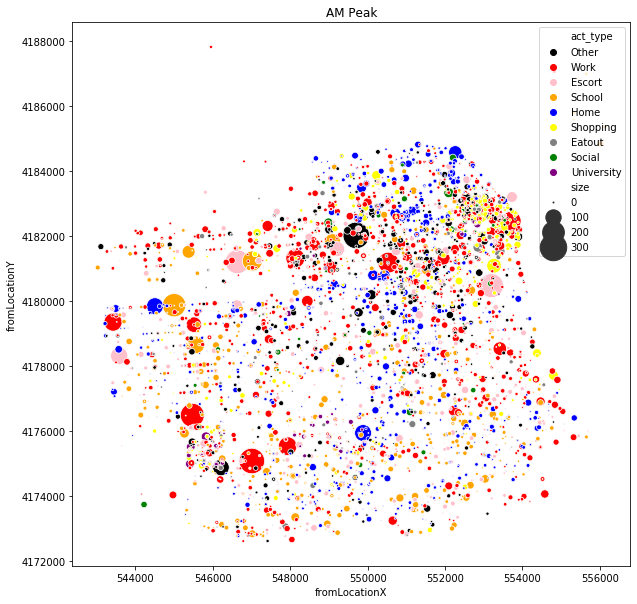

In [34]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="fromLocationX", y="fromLocationY",
              hue="act_type",
              data=am_peak_start_link,
              size='size',
              sizes=(1, 700),
              palette=color_type).set_title('AM Peak')

Text(0.5, 1.0, 'AM Peak')

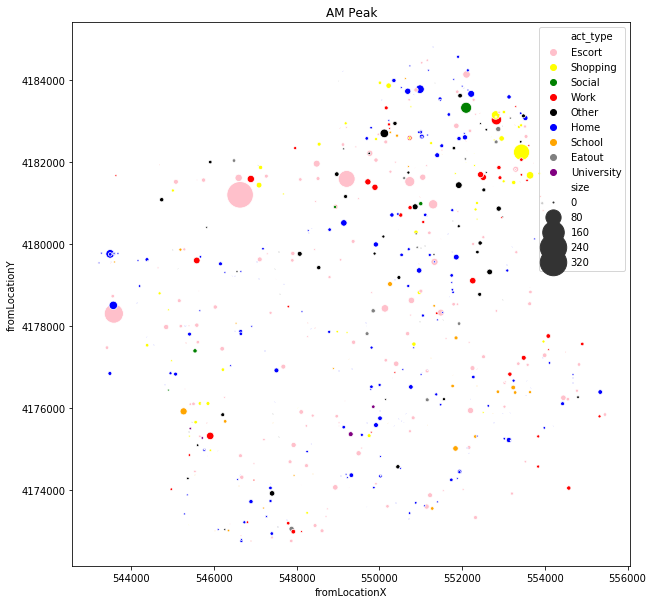

In [35]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="fromLocationX", y="fromLocationY",
              hue="act_type",
              data=am_peak_end_link,
              size='size',
              sizes=(1, 700),
              palette=color_type).set_title('AM Peak')